# Библиотеки Python для DS (семинары)

## Урок 5. Использование алгоритмов оптимизации для улучшения качества модели.

**Задание**

1. Используйте Cancer_Data для классификации. Обучите модель логистической регрессии с разными значениями скорости обучения (с разными значениями параметра C, который является обратным значением скорости обучения). Запишите и сравните результаты метрик качества и скорости сходимости модели.

2. Познакомиться с работой стохастического градиентного спуска. Используйте набор данных для обучения модели с использованием стохастического градиентного спуска (SGD - модель SGDClassifier библиотека sklearn https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html). Сравните скорость сходимости и итоговое качество модели со стандартным градиентным спуском (используйте логистическую регрессию).

3. Сравнить разные алгоритмы оптимизации.

 - Обучитe модель логистической регрессии на этих данных, используя разные оптимизаторы, и сравните их эффективность. Используйте параметр solver, который может принимать значения:
    - 'liblinear': использует координатный спуск (Coordinate Descent, CD). Хорошо подходит для небольших датасетов.
    - 'lbfgs': аппроксимация метода Бройдена – Флетчера – Гольдфарба – Шанно (BFGS). Рекомендуется для небольших и средних датасетов.
    - 'newton-cg': Ньютоновский метод сопряженных градиентов. Требует много ресурсов для больших датасетов из-за необходимости вычисления матрицы Гессе.
    - 'sag': Стохастический градиентный спуск с использованием среднего градиента. Подходит для больших датасетов.
    - 'saga': Расширение 'sag', поддерживает L1-регуляризацию, такое сочетание регуляризаций делает его вариацией метода Elastic Net.

### Подготовка

In [66]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import seaborn as sns
import time

In [67]:
# Загрузка данных
df = pd.read_csv('/content/Cancer_Data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


Эти данные представляют собой набор из 569 наблюдений, который содержит различные характеристики опухолей. Каждый столбец описывает различные свойства опухоли.

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

В данном наборе данных можно удалить следующие столбцы:

- id: Этот столбец представляет собой уникальный идентификатор каждой записи. Он не содержит полезной информации для анализа или обучения модели и может быть удален, чтобы избежать влияния на алгоритмы машинного обучения.

- Unnamed: 32: Этот столбец полностью пуст (0 значений). Он не содержит никакой информации и может быть удален без ущерба для анализа данных.

In [69]:
# Удаление ненужных столбцов
df = df.drop(columns=["id","Unnamed: 32"] )

In [70]:
df.describe(include="all").T.round(2)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
diagnosis,569,2,B,357,NaN,NaN,NaN,NaN,NaN,NaN,NaN
radius_mean,569.0,NaN,NaN,NaN,14.127292,3.524049,6.981,11.7,13.37,15.78,28.11
texture_mean,569.0,NaN,NaN,NaN,19.289649,4.301036,9.71,16.17,18.84,21.8,39.28
perimeter_mean,569.0,NaN,NaN,NaN,91.969033,24.298981,43.79,75.17,86.24,104.1,188.5
area_mean,569.0,NaN,NaN,NaN,654.889104,351.914129,143.5,420.3,551.1,782.7,2501.0
smoothness_mean,569.0,NaN,NaN,NaN,0.09636,0.014064,0.05263,0.08637,0.09587,0.1053,0.1634
compactness_mean,569.0,NaN,NaN,NaN,0.104341,0.052813,0.01938,0.06492,0.09263,0.1304,0.3454
concavity_mean,569.0,NaN,NaN,NaN,0.088799,0.07972,0.0,0.02956,0.06154,0.1307,0.4268
concave points_mean,569.0,NaN,NaN,NaN,0.048919,0.038803,0.0,0.02031,0.0335,0.074,0.2012
symmetry_mean,569.0,NaN,NaN,NaN,0.181162,0.027414,0.106,0.1619,0.1792,0.1957,0.304


Выводы:

1. В наборе данных представлено достаточно разнообразие характеристик опухолей.
2. Столбцы с высокой дисперсией могут играть важную роль в модели, так как они содержат больше информации для разделения классов.

<Axes: ylabel='Cancer'>

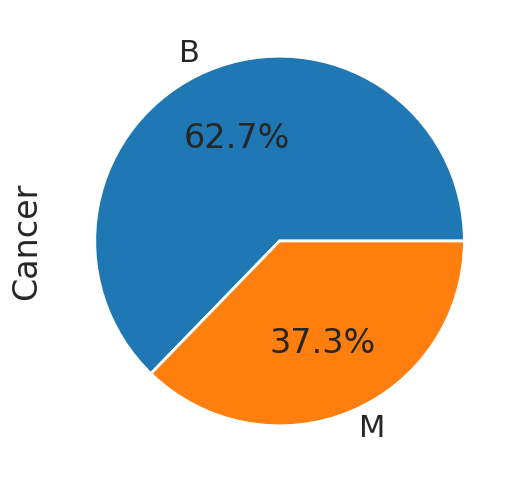

In [71]:
sns.set_style('darkgrid')
sns.set_context('poster')
plt.rcParams['figure.figsize'] = [8,6]
df.groupby('diagnosis').size().plot(kind='pie',
                                       y = "Outcome",
                                       label = "Cancer",
                                       autopct='%1.1f%%')

Наблюдаем ситуацию дисбаланса классов в данных. С долей 62.7% участников, с доброкачественной опухолью (класс "B"), и 37.3% участников, имеющих злокачественную опухоль (класс "М").Данный набор данных имеет низкое представительство одного из классов по сравнению с другим.

### 1

In [72]:
# Разделение данных на признаки и целевую переменную
X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [73]:
# Определение значений C
C_values = [0.01, 0.1, 1, 10, 100]
results = []


In [74]:
# Обучение и оценка моделей с различными значениями C
for C in C_values:
    model = LogisticRegression(C=C, max_iter=10000, random_state=42)

    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    results.append({
        'C': C,
        'Accuracy': accuracy,
        'Time': end_time - start_time
    })

In [75]:
# Преобразование результатов
results_df = pd.DataFrame(results)
print(results_df)

        C  Accuracy      Time
0    0.01  0.964912  0.131293
1    0.10  0.964912  0.330338
2    1.00  0.956140  0.679204
3   10.00  0.956140  1.004238
4  100.00  0.956140  0.917890


**Выводы:**

- Наилучшая точность была достигнута при меньших значениях С = 0.01 и 0.10.

- С увеличением значения С точность модели незначительно снижается, что может указывать на переобучение модели на тренировочные данные.
- Время выполнения модели значительно увеличивается с ростом значения С.

- На основе этих результатов можно рекомендовать использовать С = 0.01 или 0.10 для достижения оптимальной точности при умеренном времени выполнения.

### 2

In [76]:
# Логистическая регрессия
logistic_model = LogisticRegression(max_iter=10000, random_state=42)
start_time = time.time()
logistic_model.fit(X_train, y_train)
end_time = time.time()
logistic_time = end_time - start_time
logistic_accuracy = accuracy_score(y_test, logistic_model.predict(X_test))

In [77]:
# SGDClassifier
sgd_model = SGDClassifier(loss='log', max_iter=10000, random_state=42)
start_time = time.time()
sgd_model.fit(X_train, y_train)
end_time = time.time()
sgd_time = end_time - start_time
sgd_accuracy = accuracy_score(y_test, sgd_model.predict(X_test))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [78]:
# Результаты
results = {
    'Model': ['Logistic Regression', 'SGDClassifier'],
    'Accuracy': [logistic_accuracy, sgd_accuracy],
    'Time': [logistic_time, sgd_time]
}

results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy      Time
0  Logistic Regression   0.95614  0.683152
1        SGDClassifier   0.95614  0.011266


**Выводы:**

- Обе модели показывают высокую точность, что делает их подходящими для этой задачи классификации.

- SGDClassifier значительно быстрее в обучении.

### 3

In [79]:
# Список оптимизаторов
solvers = ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']
results = []

In [80]:
# Обучение и оценка моделей с различными оптимизаторами
for solver in solvers:
    model = LogisticRegression(solver=solver, max_iter=10000, random_state=42)

    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    results.append({
        'Solver': solver,
        'Accuracy': accuracy,
        'Time': end_time - start_time
    })

# Преобразование результатов
results_df = pd.DataFrame(results)
print(results_df)

      Solver  Accuracy      Time
0  liblinear  0.956140  0.025593
1      lbfgs  0.956140  0.671225
2  newton-cg  0.956140  0.118512
3        sag  0.964912  1.244115
4       saga  0.973684  1.316014


**Выводы:**

- Все оптимизаторы показывают высокую точность.
- Самую высокую точность продемонстрировал оптимизатор saga (0.973684).
- Наиболее быстрым оказался liblinear, что делает его подходящим для быстрого обучения на небольших датасетах.
- Оптимизаторы saga и sag требуют больше времени для обучения, но показывают лучшую точность.